## Vision Transformers
- [AN IMAGE IS WORTH 16 X 16 WORDS: TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE](https://arxiv.org/abs/2010.11929)

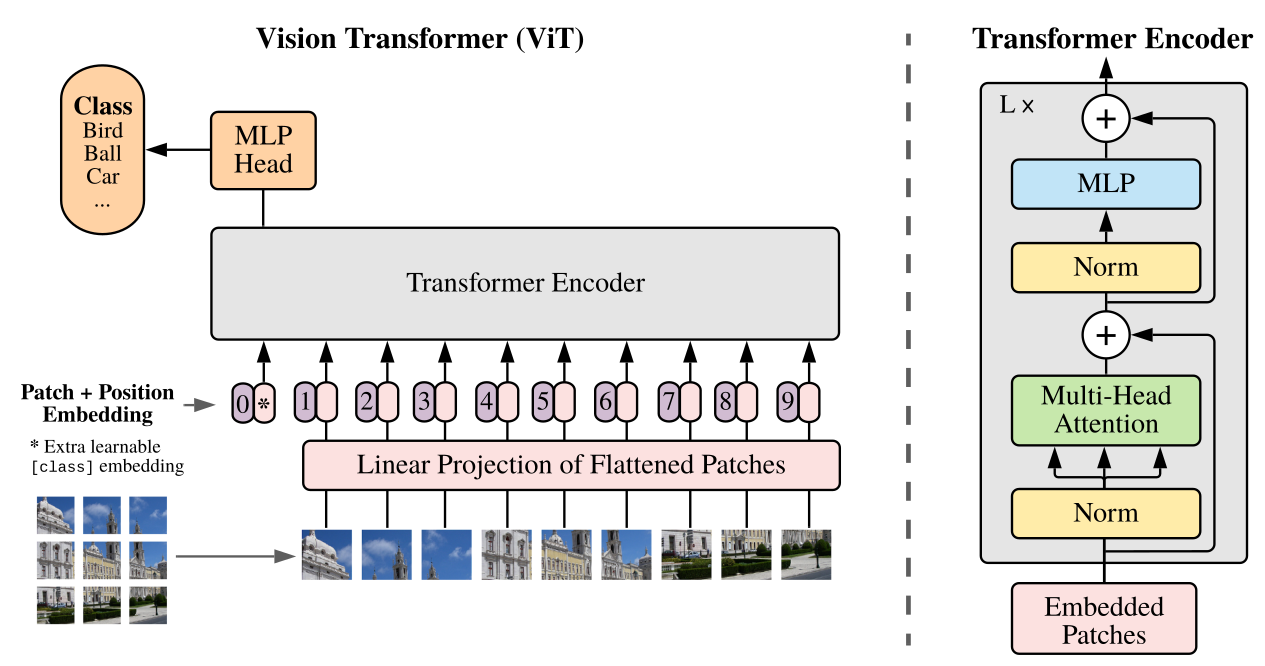

In [ ]:
!pip install ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.3 MB/s eta 0:00:00


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
os.chdir("/content/drive/My Drive/thinkAutonomous/dl_blogs/Vision-Transformer-101")

Mounted at /content/drive


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/thinkAutonomous/dl_blogs/Vision-Transformer-101'

## Imports

In [ ]:
import torch
import torch.nn as nn

## Constants

We'll be defining some hyperparmeters for the model, (correspond to VIT-small model)

In [ ]:
test_img_size = 224
patch_size = 16   # image is divided into patches of 16 x16 pixels
num_patches = (test_img_size // patch_size) * (test_img_size // patch_size)

# transformer parameters
embed_dim = 384
num_heads = 6
depth = 12

## Vision Transformer Architecture

- Only Encoder from original Transformer paper
- Cover different modules in vision Transformers
    - Patch embedding
    - Cls Token, Positional embedding
    - Layer Normalization
    - Self-Attention
    - MLP Layer
    - Transformer block
    - Putting it together


### Patch Embedding

In [ ]:
class PatchEmbed(nn.Module):
    """ Generate Patches from input image, create embeddings for each patch """
    def __init__(self, img_size, patch_size, in_chans, embed_dim):
        super().__init__()
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

In [ ]:
# (Batch size, RGB channels, height, width)
input_data = torch.Tensor(1, 3, test_img_size, test_img_size)
patch_embed = PatchEmbed(img_size=test_img_size, patch_size=patch_size, in_chans=3, embed_dim=embed_dim)
patch_embed_output = patch_embed(input_data)
print(f"Patch embedding output shape = {patch_embed_output.shape}")

Patch embedding output shape = torch.Size([1, 196, 384])


### Cls Token, Position Embedding
- Need a mechanism to inform the model of
    - Embedding class
    - Order of patches
- Positional embeddings can be either
    - Derived from mathematical function (usually involves sines and cosines of input index)
    - Learnt by model (which is current case)
    


In [ ]:
# add class token for each patch
cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
cls_token = cls_token.expand(input_data.shape[0], -1, -1)
cls_token_output = torch.cat((cls_token, patch_embed_output), dim=1)
print(f"Class token output shape = {cls_token_output.shape}")

Class token output shape = torch.Size([1, 197, 384])


**Note the usage of nn.Parameter, and not something like nn.Linear**

In [ ]:
# add positional encoding to each token
pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))

# To align with original architecture, we need to add
# dropout on the position embedding. For now, we'll define
# dropout probability as 0
pos_drop = nn.Dropout(p=0)

pos_embed_output = cls_token_output + pos_drop(pos_embed)
print(f"Position Embedding output shape = {pos_embed_output.shape}")

Position Embedding output shape = torch.Size([1, 197, 384])


### Self-Attention

In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads, attn_drop, proj_drop):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=True)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x) # (1, 197, 3 * 384), contains query, key and values
        qkv = qkv.reshape(B, N, 3, self.num_heads, C // self.num_heads)  # (1, 197, 3, 6, 64)

        # (qkv, batch_size, num_heads, num_tokens, dim_per_head)
        qkv =qkv.permute(2, 0, 3, 1, 4)  # (3, 1, 6, 197, 64)

        # query, key, values all are of (1,6,197,64) shape
        q, k, v = qkv[0], qkv[1], qkv[2]

        # query (1,6,197,64) * key (1,6,64, 197) = (1,6,197,197)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        # attn (1,6,197,197) * value (1,6,197,64) = (1,6,197,64)
        x = (attn @ v)

        # (1,6,197,64) -> (1,197,6,64) -> (1,197,384)
        x = x.transpose(1, 2).reshape(B, N, C)

        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn

In [ ]:
attention_module = Attention(dim = embed_dim, num_heads = num_heads, attn_drop =0.0, proj_drop =0.0 )
attn_output, attn = attention_module(pos_embed_output)
print(f"Attention output shape = {attn_output.shape}")
print(f"Attention shape = {attn.shape}")

Attention output shape = torch.Size([1, 197, 384])
Attention shape = torch.Size([1, 6, 197, 197])


### MLP module

In [ ]:
class Mlp(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hid_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hid_dim, out_dim)
        self.drop = nn.Dropout(0.0)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

### Transformer block

In [ ]:
class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, attn_drop=0, proj_drop=0)
        self.norm2 = nn.LayerNorm(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_dim=dim, hid_dim=mlp_hidden_dim, out_dim=dim)

    def forward(self, x, return_attention=False):
        y, attn = self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x, attn

In [ ]:
transformer_block = Block(dim=embed_dim, num_heads=3, mlp_ratio=4)
transformer_block_output, _ = transformer_block(pos_embed_output)
print(f"Transformer block output shape = {transformer_block_output.shape}")

Transformer block output shape = torch.Size([1, 197, 384])


### Putting it altogether

In [ ]:
import math

class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_chans, embed_dim, depth, num_heads, mlp_ratio):
        super().__init__()
        self.num_features = self.embed_dim = embed_dim
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=0.0)

        self.blocks = nn.ModuleList([
            Block(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio)
            for i in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)

    # practical consideration, where input image is
    # not square, but out positional encoding is. We need
    # to interpolate the positional encoding
    def interpolate_pos_encoding(self, x, w, h):
        npatch = x.shape[1] - 1
        N = self.pos_embed.shape[1] - 1
        if npatch == N and w == h:
            return self.pos_embed

        # unwrap embedding to class and position embedding
        # (1, 197, 384) -> class (1, 1, 384) and pos_emb (1, 196, 384)
        class_pos_embed = self.pos_embed[:, 0]
        patch_pos_embed = self.pos_embed[:, 1:]
        dim = x.shape[-1]
        w0 = (w // self.patch_embed.patch_size) + 0.1  # to avoid floating point error
        h0 = (h // self.patch_embed.patch_size) + 0.1  # to avoid floating point error
        patch_pos_embed = nn.functional.interpolate(
            patch_pos_embed.reshape(1, int(math.sqrt(N)), int(math.sqrt(N)), dim).permute(0, 3, 1, 2),
            scale_factor=(w0 / math.sqrt(N), h0 / math.sqrt(N)),
            mode='bicubic',
        )
        patch_pos_embed = patch_pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
        return torch.cat((class_pos_embed.unsqueeze(0), patch_pos_embed), dim=1)

    def prepare_tokens(self, x):
        B, nc, w, h = x.shape
        x = self.patch_embed(x)  # patch linear embedding

        # add the [CLS] token to the embed patch tokens
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # add positional encoding to each token
        x = x + self.interpolate_pos_encoding(x, w, h)
        return self.pos_drop(x)

    def forward(self, x):
        x = self.prepare_tokens(x)
        for i, blk in enumerate(self.blocks):
            x, attn_map = blk(x)
        x = self.norm(x)
        return x, attn_map

In [ ]:
vit = VisionTransformer(img_size=test_img_size, patch_size=patch_size, in_chans=3,
                        embed_dim=embed_dim, depth=depth, num_heads=num_heads, mlp_ratio=4)

vit_output, attn_map = vit(input_data)
vit_output.shape, attn_map.shape

(torch.Size([1, 197, 384]), torch.Size([1, 6, 197, 197]))

In [ ]:
input_data = torch.Tensor(1,3, 512, 1024)
vit_output, attn_map = vit(input_data)
vit_output.shape, attn_map.shape

(torch.Size([1, 2049, 384]), torch.Size([1, 6, 2049, 2049]))

## Visualize Attention

We'll load a pretrained model, and visualized the output on sample images

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# load pretrained model
checkpoint = torch.load('vit_small_16_dino_backbone.pth')
vit.load_state_dict(checkpoint)
vit.eval();
vit.to(device);

In [ ]:
import cv2
from torchvision import transforms as pth_transforms

transform = pth_transforms.Compose([
        pth_transforms.ToTensor(),
        pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])


def preprocess_image(image_path, patch_size, reshape_size=None):
    rgb_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    if reshape_size is not None:
        rgb_image = cv2.resize(rgb_image, reshape_size, interpolation=cv2.INTER_LINEAR)
    img = transform(rgb_image)
    _, image_height, image_width = img.shape

    # make the image divisible by the patch size
    w, h = image_width - image_width % patch_size, image_height - image_height % patch_size
    img = img[:, :h, :w].unsqueeze(0)

    w_featmap = img.shape[-1] // patch_size
    h_featmap = img.shape[-2] // patch_size
    return rgb_image, img, w_featmap, h_featmap

In [ ]:
test_img_path = 'stuttgart_00_000000_000001.png'
rgb_image, img, w_featmap, h_featmap = preprocess_image(test_img_path, patch_size=patch_size) #  reshape_size=(512, 256)
print(f"rgb_image shape = {rgb_image.shape}, img shape = {img.shape}")

rgb_image shape = (512, 1024, 3), img shape = torch.Size([1, 3, 512, 1024])


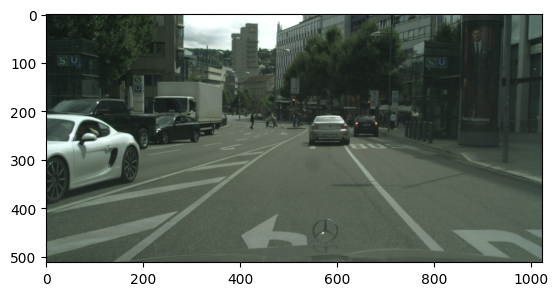

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(rgb_image)

In [ ]:
# get last stage attention
with torch.no_grad():
    img = img.to(device)
    _, attentions = vit(img)

attentions = attentions.cpu().detach().numpy()[0, :, 1:, 1:]
print(f"Attentions shape = {attentions.shape}")

Attentions shape = (6, 2048, 2048)


We'll visualize attention maps from different heads for a single pixel

In [ ]:
# def calculate_th_attention(attention_map, threshold):
#     # we keep only a certain percentage of the mass
#     idx = np.argsort(attention_map)
#     val = np.take_along_axis(attention_map, idx, axis=-1)
#     val /= np.sum(val, axis=1, keepdims=True)
#     cumval = np.cumsum(val, axis=1)
#     th_attn = cumval > (1 - threshold)
#     idx2 = np.argsort(idx)
#     for head in range(attentions.shape[0]):
#         th_attn[head] = th_attn[head][idx2[head]]
#     return th_attn.astype(np.uint8)

In [ ]:
import numpy as np
import matplotlib.patches as patches
import IPython.display as Disp
from ipywidgets import Button, Layout

class Visualize_Attention():
    def __init__(self, rgb_image, attention_map, patch_size =16, figsize=(9,7), cmap='jet'):
        self.rgb_image = rgb_image
        self.attention_map = attention_map
        self.ps = patch_size
        self.img_height, self.img_width, _ = self.rgb_image.shape

        self.fig = plt.figure(figsize=figsize)
        gs = self.fig.add_gridspec(nrows=3, ncols=3) # hspace =0, wspace=0

        # RGB image with gridlines
        self.rgb_axes = self.fig.add_subplot(gs[0, :])
        self.rgb_axes.imshow(self.rgb_image)
        self.rgb_axes.set(xticks=[], yticks=[])
        for x in range(0, self.img_width, self.ps):
            self.rgb_axes.axvline(x, color='gray', linestyle='-', linewidth = 0.25)
        for y in range(0, self.img_height, self.ps):
            self.rgb_axes.axhline(y, color='gray', linestyle='-', linewidth = 0.25)
        self.rect = None

        # attention maps subplot
        self.attn_head_axes = []
        for row in range(1,3):
            for col in range(0, 3):
                head_axes = self.fig.add_subplot(gs[row, col])
                im = head_axes.imshow(np.zeros((self.img_height, self.img_width)))
                head_axes.set(xticks=[], yticks=[])
                self.attn_head_axes.append(head_axes)
        self.fig.tight_layout()

        # triggers
        self.trigger = self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        visualize_button = Button(description = "Visualize Attention Heads", layout = Layout(positioning='top'))
        Disp.display(visualize_button)
        visualize_button.on_click(self.plot_patch_attention)

    def onclick(self, event):
        if event.inaxes == self.rgb_axes:
            self.patch_x = int(event.xdata // self.ps)
            self.patch_y = int(event.ydata // self.ps)
            if(self.rect is not None):
                self.rect.remove()
            self.rect = patches.Rectangle((self.patch_x * self.ps, self.patch_y * self.ps),
                                      self.ps, self.ps, linewidth=1, ec='r', fc='none')
            self.rgb_axes.add_patch(self.rect)


    def plot_patch_attention(self, _):
        # plot attention maps of all heads of corresponding patch
        patch_attn = self.attention_map[:, self.patch_x * self.ps + self.patch_y]
        patch_attn = patch_attn.reshape(-1, self.img_height // self.ps, self.img_width // self.ps)
#         th_patch_attn = calculate_th_attention(patch_attn.reshape(6, -1), threshold=0.6)
#         th_patch_attn = th_patch_attn.reshape(-1, self.img_height // self.ps, self.img_width // self.ps)
#         th_patch_attn = cv2.blur(th_patch_attn,(10,10))

        for hi, ax in enumerate(self.attn_head_axes):
            ax.clear()
            patch_attn_i = cv2.resize(patch_attn[hi], (self.img_width, self.img_height), cv2.INTER_LINEAR)
            im = ax.imshow(patch_attn_i, cmap='jet')
            ax.set(xticks=[], yticks=[])
            self.fig.subplots_adjust(wspace=0, hspace=0)

Button(description='Visualize Attention Heads', style=ButtonStyle())

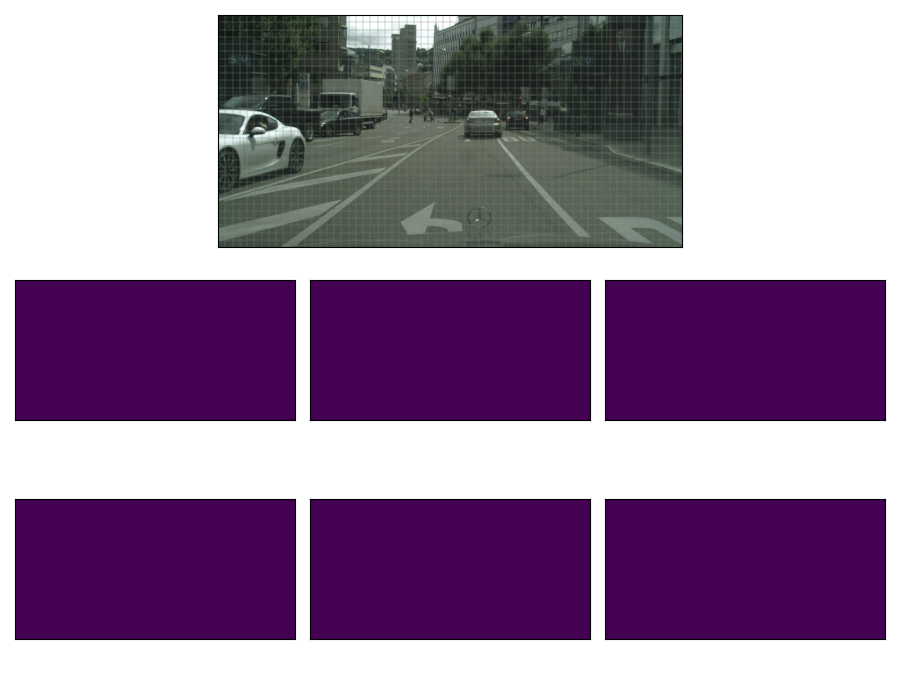

In [ ]:
%matplotlib ipympl
from google.colab import output
output.enable_custom_widget_manager()

visualizer = Visualize_Attention(rgb_image, attentions)

## References